In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

from dispersant_screener.utils import read_pickle, get_random_exploration_bl
from pypal.pal.utils import get_hypervolume
import numpy as np 
from functools import partial
from matplotlib import animation, rc
import pandas as pd

COLORS = [
    "#ffbe0b", 
    "#fb5607", 
    "#ff006e",
    "#3a86ff", 
]

In [12]:
pmof_test = pd.read_csv('../data/PMOF20K_traindata_7000_test.csv')
pmof_train = pd.read_csv('../data/PMOF20K_traindata_7000_train.csv')
pmof = pd.concat([pmof_test, pmof_train])
pmof['CO2_DC'] = pmof['pure_uptake_CO2_298.00_1600000'] - pmof['pure_uptake_CO2_298.00_15000']
y = pmof[['CO2_DC', 'CH4DC']].values

In [4]:
discarded = np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-discarded.npy', allow_pickle=True)
unclassified = np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-unclassified.npy', allow_pickle=True)
pareto_optimal = np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-pareto_optimal_indices.npy', allow_pickle=True)
selected = np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-selected.npy', allow_pickle=True)

greedy_indices = np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-greedy_indices.npy', allow_pickle=True)

hvs = list(np.load('../work/20201021-160549_MOF_0.05_0.05_0.05_300-hypervolumes.npy', allow_pickle=True))

In [5]:
def get_summary_stats_time(): 
    pareto_points = []
    non_pareto_points = []
    sampled_points = []
    unclassified_points = []
    
    for array in pareto_optimal:
        pareto_points.append(len(array))
        
    for array in discarded:
        non_pareto_points.append(len(array))
    
    for array in selected:
        sampled_points.append(len(array))
        
    for array in unclassified: 
        unclassified_points.append(len(array))
    
    return pareto_points, non_pareto_points, sampled_points, unclassified_points

In [6]:
pareto_points, non_pareto_points, sampled_points, unclassified_points = get_summary_stats_time()

In [14]:
REFERENCE_HV = get_hypervolume(y, [5,5])

In [15]:
random_explorations = np.load('random_exploration_mof_case_study.npy')
random_exploration_median = np.median(random_explorations, axis=0)
random_exploration_std = np.std(random_explorations, axis=0)

In [17]:
hvs_padded = np.array([hvs[0]] * 300 + hvs)

 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
 /Users/kevinmaikjablonka/opt/miniconda3/envs/dispersant_basf/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning:
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two mi

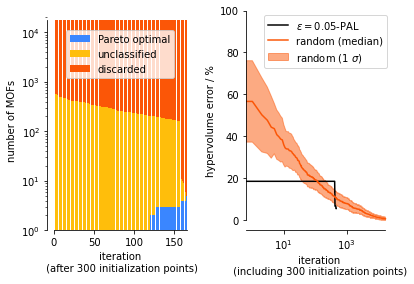

In [33]:
fig, ax = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1]})
ax[0].bar(range(len(pareto_optimal)), 
          pareto_points, 
          label='Pareto optimal', color=COLORS[3])
ax[0].bar(range(len(pareto_optimal)), unclassified_points, bottom=pareto_points, label='unclassified', color=COLORS[0])
ax[0].bar(range(len(pareto_optimal)), non_pareto_points, bottom=np.array(unclassified_points) + np.array(pareto_points), label='discarded', color=COLORS[1])
ax[0].set_xlabel('iteration\n (after 300 initialization points)')
ax[1].set_xlabel('iteration\n (including 300 initialization points)')
ax[0].set_ylabel('number of MOFs')
ax[1].set_ylabel('hypervolume error / %')

ax[0].spines['left'].set_smart_bounds(True)
ax[0].spines['bottom'].set_smart_bounds(True)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

ax[1].spines['left'].set_smart_bounds(True)
ax[1].spines['bottom'].set_smart_bounds(True)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

ax[1].plot((REFERENCE_HV-hvs_padded)/REFERENCE_HV * 100, label=r'$\epsilon=0.05$-PAL', c='black')
#ax[1].plot((REFERENCE_HV-hvs_b_padded)/REFERENCE_HV * 100, label=r'$\epsilon=0.1$-PAL', c='black', ls='dotted')

ax[1].plot((REFERENCE_HV-np.array(random_exploration_median))/REFERENCE_HV * 100, 
           label='random (median)', c=COLORS[1])
ax[1].fill_between(np.arange(len(y)),
                   (REFERENCE_HV-np.array(random_exploration_median + random_exploration_std))/REFERENCE_HV * 100, (REFERENCE_HV-np.array(random_exploration_median - random_exploration_std))/REFERENCE_HV * 100, 
                   label=r'random (1 $\sigma$)', color=COLORS[1], alpha=.5)
#ax[1].plot(ratios)
ax[1].legend()

fig.tight_layout()

ax[0].set_yscale('log')
ax[1].set_xscale('log')

ax[0].legend(loc='right', bbox_to_anchor=(0.9,0.8))

fig.savefig('mof_case_study.pdf', bbox_inches='tight')

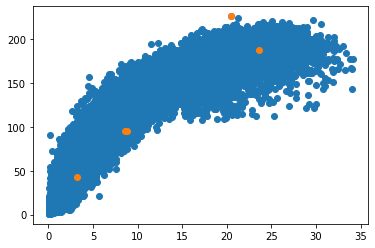

In [38]:
plt.scatter(y[:,0], y[:,1])
plt.scatter(y[pareto_optimal[-1],0], y[pareto_optimal[-1],1])

In [40]:
pareto_optimal[-1]

array([  378,  5726,  8180, 13349, 13567])